In [1]:
%matplotlib inline
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle
import pandas as pd
import sys
sys.path.insert(0, "../SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.PSF import PSF_generator
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from SyMBac.renderer import convolve_rescale
from tqdm.auto import tqdm
from skimage import color, data, restoration
from matplotlib.colors import LogNorm
from joblib import Parallel, delayed

import matplotlib
matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

In [2]:
pix_mic_conv = 0.065 / 15
resize_amount = 1

In [3]:
cell_length = 3 #micron
cell_width = 1.01999 #micron
raster_cell_length = cell_length / pix_mic_conv
raster_cell_width = cell_width / pix_mic_conv
def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount = False):


    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [4]:
raster_cell_width

235.3823076923077

In [5]:
membrane_cell = np.pad(raster_membrane_cell_3d(raster_cell_length,raster_cell_width), ((1,1),(50,50),(50,50)))
print(membrane_cell.shape)

(236, 792, 336)


In [7]:
conv = tifffile.imread("../../single_cell_projection_diffraction/targeted_simulation_output/1.0199999999999998_iPSF_ePSF_darkred.tiff")

In [8]:
PSF_darkred = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_darkred.tif")[70:-70,80:-80,80:-80]
PSF_green = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_green.tif")[70:-70,80:-80,80:-80]
PSF_orange = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_orange.tif")[70:-70,80:-80,80:-80]

In [9]:
def prepare_ePSF(ePSF, pix_size_original_z, pix_size_original_xy, pix_size_new):
    ePSF = rescale(ePSF, (pix_size_original_z/pix_size_new, pix_size_original_xy / pix_size_new, pix_size_original_xy / pix_size_new), anti_aliasing=True)
    ePSF = ePSF - ePSF.min(axis=(1, 2))[:, np.newaxis, np.newaxis]
    return ePSF

real_PSFs = {
    "ePSF_darkred" : prepare_ePSF(PSF_darkred, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv),
    "ePSF_green" : prepare_ePSF(PSF_green, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv)
}

/tmp/ipykernel_3268534/2073476948.py:5: RuntimeWarning: invalid value encountered in divide
  profile = profile/profile.max()


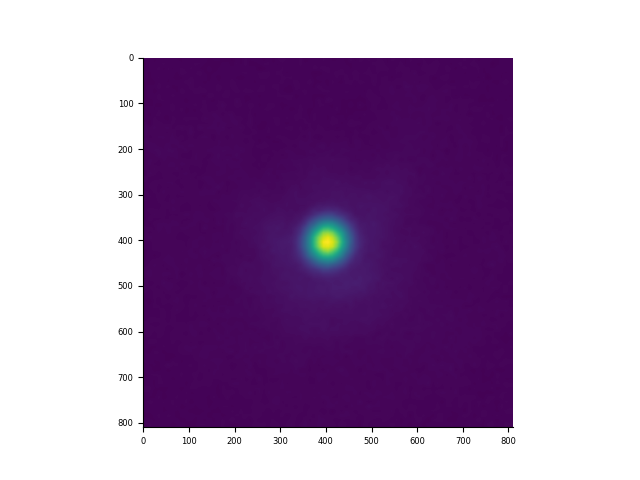

In [10]:
from scipy.signal import find_peaks
profile_integral = []
for layer in real_PSFs["ePSF_darkred"]:
    profile = layer[:,real_PSFs["ePSF_darkred"].shape[1]//2]
    profile = profile/profile.max()
    profile_integral.append(-np.cumsum(profile)[-1])
profile_integral = np.array(profile_integral)

plt.plot(profile_integral)
peaks = find_peaks(profile_integral, height = -110, prominence=10)[0]
plt.scatter(peaks, profile_integral[peaks])
PSF_darkred_centre_z = peaks[0] - 17*3 # Check how the peaks line up with the tails
plt.imshow(real_PSFs["ePSF_darkred"][PSF_darkred_centre_z])

In [11]:
from cucim.skimage.restoration import richardson_lucy as richardson_lucy_cuda
import cupy as cp

In [12]:
deconv_kernel = real_PSFs["ePSF_darkred"][PSF_darkred_centre_z-conv.shape[0]//2:PSF_darkred_centre_z+conv.shape[0]//2].sum(axis=0)
img_to_deconv = conv.sum(axis=0)

In [37]:
deconv_img = richardson_lucy_cuda(cp.array(img_to_deconv/img_to_deconv.sum()), cp.array(deconv_kernel),200).get()
deconv_img = np.concatenate([deconv_img[:350], deconv_img[-350:]])
deconv_img = np.concatenate([deconv_img[:,:deconv_img.shape[1]//2], deconv_img[:,:-deconv_img.shape[1]//2][:,::-1]], axis = 1)

In [38]:
tifffile.imwrite("deconv_img.tiff", deconv_img)
tifffile.imwrite("img_to_deconv.tiff", img_to_deconv)
tifffile.imwrite("membrane_cell.tiff",membrane_cell)

In [39]:
deconv_profile = deconv_img[300]
conv_profile = img_to_deconv[300]
unconv_profile = membrane_cell.sum(axis=0)[300]

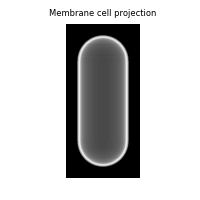

In [40]:
plt.figure(figsize=(2,2))
plt.imshow(np.concatenate([membrane_cell.sum(axis=0)[:350], membrane_cell.sum(axis=0)[-350:]]), cmap="Greys_r")
plt.axis("off")
plt.title("Membrane cell projection")
plt.savefig("unconvolved.svg")

In [41]:
membrane_cell.sum(axis=0).shape

(792, 336)

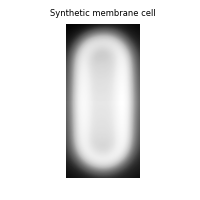

In [42]:
plt.figure(figsize=(2,2))
plt.imshow(np.concatenate([img_to_deconv[:350], img_to_deconv[-350:]]), cmap="Greys_r")
plt.axis("off")
plt.title("Synthetic membrane cell")
plt.savefig("convolved.svg")

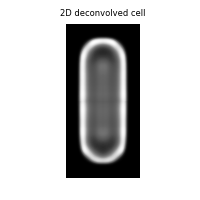

In [43]:
plt.figure(figsize=(2,2))
plt.title("2D deconvolved cell")
plt.imshow(deconv_img, cmap="Greys_r")
plt.axis("off")
plt.savefig("deconvolved.svg")

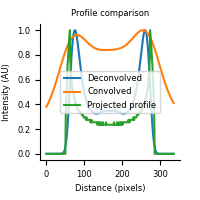

In [22]:
plt.figure(figsize=(2,2))
plt.plot(deconv_profile/deconv_profile.max(), label = "Deconvolved")
plt.plot(conv_profile/conv_profile.max(), label = "Convolved")
plt.plot(unconv_profile/unconv_profile.max(), label = "Projected profile")
plt.title("Profile comparison")
plt.legend()
plt.xlabel("Distance (pixels)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.2, bottom = 0.2)
plt.savefig("profiles.svg")